# CT/MRI Classification By MobileNetV2

- Here we use the MobileNetV2 architecture to classify whether an image is a CT or MRI scan of a brain tumor.
- This is only an empirical proxy to check if the augmentations generated are unrealistic or not.
- As a result, we will not be training the convolution part, only the FC layers.
- Note that this will not be used as the actual classifier for CT/MRI in the final model.

In [1]:
# Importing necessary libraries

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torchsummary import summary

import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score

import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
# Instead of automatic detection
device = torch.device("cuda:0")  # Force GPU 0
print(f"Using device: {device}")

Using device: cuda:0


In [3]:
import random

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
# Downloading the dataset

import kagglehub

# Download latest version
path = kagglehub.dataset_download("murtozalikhon/brain-tumor-multimodal-image-ct-and-mri")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Ankit Dey\.cache\kagglehub\datasets\murtozalikhon\brain-tumor-multimodal-image-ct-and-mri\versions\1


In [5]:
# Extract image paths and create CT/MRI labels

import glob
from pathlib import Path

# Initialize lists to store paths and labels
image_paths = []
labels = []

# Define the main dataset path
dataset_path = Path(path)

# Define the two main folders
ct_folder = dataset_path / "Dataset" /"Brain Tumor CT scan Images"
mri_folder = dataset_path / "Dataset" / "Brain Tumor MRI images"

# Common image extensions
image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff', '*.tif']

# Function to get all image files from a directory
def get_image_files(folder_path):
    image_files = []
    for ext in image_extensions:
        image_files.extend(glob.glob(str(folder_path / "**" / ext), recursive=True))
    return image_files

# Extract CT images
if ct_folder.exists():
    ct_images = get_image_files(ct_folder)
    image_paths.extend(ct_images)
    labels.extend(['CT'] * len(ct_images))
    print(f"Found {len(ct_images)} CT images")
else:
    print(f"CT folder not found: {ct_folder}")

# Extract MRI images  
if mri_folder.exists():
    mri_images = get_image_files(mri_folder)
    image_paths.extend(mri_images)
    labels.extend(['MRI'] * len(mri_images))
    print(f"Found {len(mri_images)} MRI images")
else:
    print(f"MRI folder not found: {mri_folder}")

print(f"\nTotal images found: {len(image_paths)}")
print(f"CT images: {labels.count('CT')}")
print(f"MRI images: {labels.count('MRI')}")

# Display first few examples
print("\nFirst 5 image paths and labels:")
for i in range(min(5, len(image_paths))):
    print(f"{labels[i]}: {image_paths[i]}")

Found 4618 CT images
Found 5000 MRI images

Total images found: 9618
CT images: 4618
MRI images: 5000

First 5 image paths and labels:
CT: C:\Users\Ankit Dey\.cache\kagglehub\datasets\murtozalikhon\brain-tumor-multimodal-image-ct-and-mri\versions\1\Dataset\Brain Tumor CT scan Images\Healthy\ct_healthy (1).jpg
CT: C:\Users\Ankit Dey\.cache\kagglehub\datasets\murtozalikhon\brain-tumor-multimodal-image-ct-and-mri\versions\1\Dataset\Brain Tumor CT scan Images\Healthy\ct_healthy (10).jpg
CT: C:\Users\Ankit Dey\.cache\kagglehub\datasets\murtozalikhon\brain-tumor-multimodal-image-ct-and-mri\versions\1\Dataset\Brain Tumor CT scan Images\Healthy\ct_healthy (100).jpg
CT: C:\Users\Ankit Dey\.cache\kagglehub\datasets\murtozalikhon\brain-tumor-multimodal-image-ct-and-mri\versions\1\Dataset\Brain Tumor CT scan Images\Healthy\ct_healthy (1000).jpg
CT: C:\Users\Ankit Dey\.cache\kagglehub\datasets\murtozalikhon\brain-tumor-multimodal-image-ct-and-mri\versions\1\Dataset\Brain Tumor CT scan Images\Health

In [6]:
# Creating a dataframe out of the extracted file paths and the labels

data_df = pd.DataFrame(zip(image_paths, labels), columns=['image_paths', 'labels'])
data_df.head()

,image_paths,labels
0,C:\Users\Ankit Dey\.cache\kagglehub\datasets\m...,CT
1,C:\Users\Ankit Dey\.cache\kagglehub\datasets\m...,CT
2,C:\Users\Ankit Dey\.cache\kagglehub\datasets\m...,CT
3,C:\Users\Ankit Dey\.cache\kagglehub\datasets\m...,CT
4,C:\Users\Ankit Dey\.cache\kagglehub\datasets\m...,CT


In [7]:
# Train Test Split (70-30)

train = data_df.sample(frac=0.7, random_state=7)
test = data_df.drop(train.index)

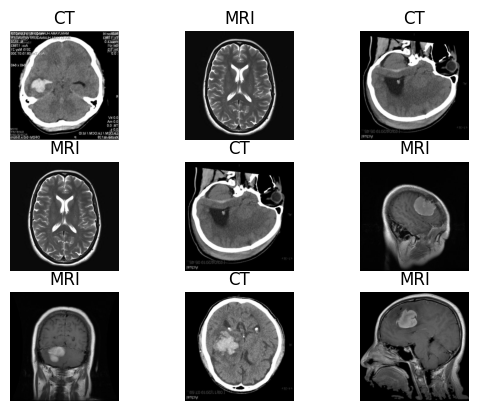

In [8]:
# Data Visualization

n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
c = 0
for row in range(n_rows):
    for col in range(n_cols):
        tuple = train.iloc[c * row + col]
        image = Image.open(tuple['image_paths']).convert("RGB")
        axarr[row, col].imshow(image)
        axarr[row, col].axis('off')
        axarr[row, col].set_title(tuple['labels'])
    c += 1

plt.show()

In [9]:
# Encode classes to numeric values

label_encoder = LabelEncoder()
label_encoder.fit(data_df['labels'])

LabelEncoder()

In [10]:
# Necessary transformations for MobileNetv2

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [11]:
# Hyperparameters

LEARNING_RATE = 1e-3
BATCH_SIZE = 128
EPOCHS = 3

In [12]:
# Creating dataset class

class dataset(Dataset):

    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe['labels']))

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, ind):
        img_path = self.dataframe['image_paths'].iloc[ind]
        label = self.labels[ind]
        image = Image.open(img_path).convert('RGB')
        if (self.transform):
            image = self.transform(image)
        return image, label

In [13]:
# Creating datasets

train_dataset = dataset(dataframe=train, transform=transform)
test_dataset = dataset(dataframe=test, transform=transform)

In [14]:
# Creating Dataloaders

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

In [15]:
# Getting MobileNetV2

model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

Using cache found in C:\Users\Ankit Dey/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Work\VS Code\ml-research-project\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Work\VS Code\ml-research-project\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
# Checking model parameters

model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [17]:
# Freezing all parameters

for param in model.parameters():
    param.requires_grad = False

# Replacing the classifier for binary Classification

model.classifier[1] = nn.Linear(model.last_channel, 2)

In [18]:
# Moving model to device

model = model.to(device)

In [19]:
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
             ReLU6-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
       BatchNorm2d-5         [-1, 32, 128, 128]              64
             ReLU6-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 16, 128, 128]             512
       BatchNorm2d-8         [-1, 16, 128, 128]              32
  InvertedResidual-9         [-1, 16, 128, 128]               0
           Conv2d-10         [-1, 96, 128, 128]           1,536
      BatchNorm2d-11         [-1, 96, 128, 128]             192
            ReLU6-12         [-1, 96, 128, 128]               0
           Conv2d-13           [-1, 96, 64, 64]             864
      BatchNorm2d-14           [-1, 96,

In [20]:
# Setting Loss & Optimizer

loss = nn.BCEWithLogitsLoss()
optimizer = Adam(model.classifier.parameters(), lr=LEARNING_RATE)

In [21]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(torch.version.cuda)

True
NVIDIA GeForce GTX 1650
12.8


In [22]:
# Training loop for MobileNetV2

total_loss_train_plot = []
total_acc_train_plot = []
total_precision_train_plot = []
total_loss_test_plot = []
total_acc_test_plot = []
total_precision_test_plot = []

for epoch in range(EPOCHS):
    print(f"Starting epoch {epoch+1}")
    epoch_loss = 0
    epoch_acc = 0
    # all_preds = []
    # all_labels = []

    model.train()
    print("About to start training loop...")
    
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        batch_loss = loss(outputs, nn.functional.one_hot(labels, num_classes=2).float())
        batch_loss.backward()
        optimizer.step()
        
        # Keep on GPU - no sync during training loop
        epoch_loss += batch_loss.detach()  # Remove .item()
        preds = torch.argmax(outputs, dim=1)
        epoch_acc += (preds == labels).sum()
        
        # Store predictions on GPU during training
        if batch_idx == 0:
            all_preds_gpu = preds
            all_labels_gpu = labels
        else:
            all_preds_gpu = torch.cat([all_preds_gpu, preds])
            all_labels_gpu = torch.cat([all_labels_gpu, labels])

    # SYNC ONLY AT END - convert to CPU once per epoch
    avg_train_loss = epoch_loss.item() / len(train_loader)  # Sync here
    train_accuracy = (epoch_acc.item() / len(train_dataset)) * 100  # Sync here
    train_precision = precision_score(all_labels_gpu.cpu().numpy(), all_preds_gpu.cpu().numpy(), average='macro') * 100  # Sync here

    total_loss_train_plot.append(round(avg_train_loss, 4))
    total_acc_train_plot.append(round(train_accuracy, 4))
    total_precision_train_plot.append(round(train_precision, 4))

    # Test phase
    model.eval()
    test_loss = 0
    test_acc = 0
    test_preds = []
    test_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            batch_loss = loss(outputs, nn.functional.one_hot(labels, num_classes=2).float())
            test_loss += batch_loss.detach()

            preds = torch.argmax(outputs, dim=1)
            batch_acc = (preds == labels).sum()
            test_acc += batch_acc

            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss.item() / len(test_loader)
    test_accuracy = test_acc.item() / len(test_dataset) * 100
    test_precision = precision_score(test_labels, test_preds, average='macro') * 100

    total_loss_test_plot.append(round(avg_test_loss, 4))
    total_acc_test_plot.append(round(test_accuracy, 4))
    total_precision_test_plot.append(round(test_precision, 4))

    print(f'''Epoch {epoch+1}/{EPOCHS}, 
    Train Loss: {round(avg_train_loss, 4)} | Train Accuracy: {round(train_accuracy, 4)}% | Train Precision: {round(train_precision, 4)}%
    Test Loss: {round(avg_test_loss, 4)} | Test Accuracy: {round(test_accuracy, 4)}% | Test Precision: {round(test_precision, 4)}%''')
    print("="*50)

Starting epoch 1
About to start training loop...
Epoch 1/3, 
    Train Loss: 0.1839 | Train Accuracy: 97.0147% | Train Precision: 97.0409%
    Test Loss: 0.0543 | Test Accuracy: 99.7227% | Test Precision: 99.7182%
Starting epoch 2
About to start training loop...
Epoch 1/3, 
    Train Loss: 0.1839 | Train Accuracy: 97.0147% | Train Precision: 97.0409%
    Test Loss: 0.0543 | Test Accuracy: 99.7227% | Test Precision: 99.7182%
Starting epoch 2
About to start training loop...
Epoch 2/3, 
    Train Loss: 0.0425 | Train Accuracy: 99.5099% | Train Precision: 99.5072%
    Test Loss: 0.0268 | Test Accuracy: 99.792% | Test Precision: 99.7875%
Starting epoch 3
About to start training loop...
Epoch 2/3, 
    Train Loss: 0.0425 | Train Accuracy: 99.5099% | Train Precision: 99.5072%
    Test Loss: 0.0268 | Test Accuracy: 99.792% | Test Precision: 99.7875%
Starting epoch 3
About to start training loop...
Epoch 3/3, 
    Train Loss: 0.0285 | Train Accuracy: 99.6287% | Train Precision: 99.6262%
    Tes

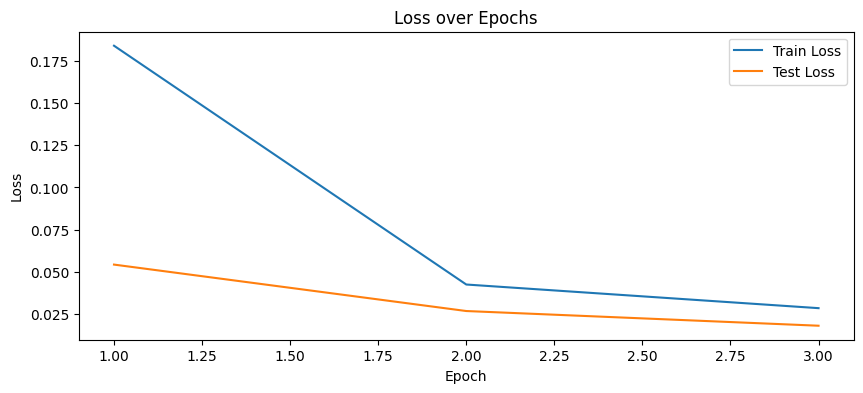

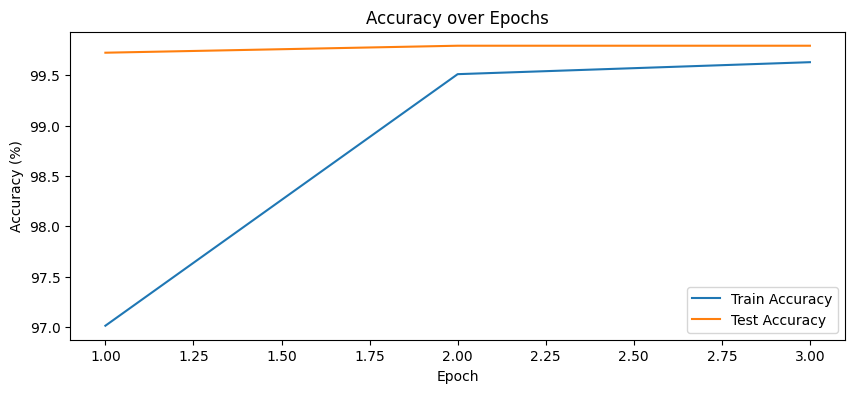

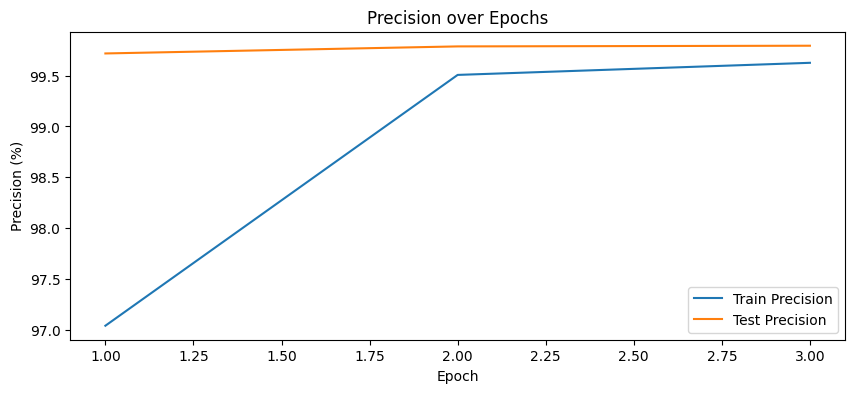

In [23]:
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)

# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(epochs, total_loss_train_plot, label='Train Loss')
plt.plot(epochs, total_loss_test_plot, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.plot(epochs, total_acc_train_plot, label='Train Accuracy')
plt.plot(epochs, total_acc_test_plot, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

# Plot Precision
plt.figure(figsize=(10, 4))
plt.plot(epochs, total_precision_train_plot, label='Train Precision')
plt.plot(epochs, total_precision_test_plot, label='Test Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision (%)')
plt.title('Precision over Epochs')
plt.legend()
plt.show()

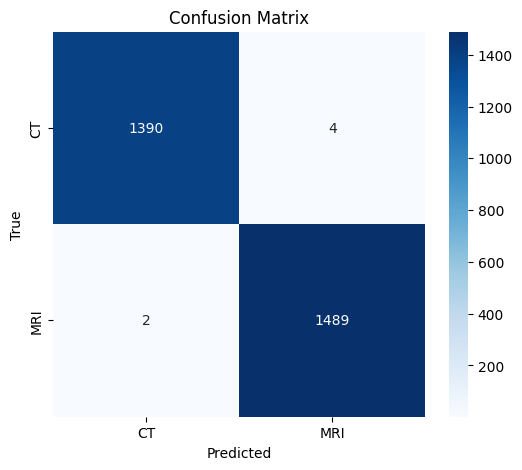

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# After test phase
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['CT', 'MRI'], yticklabels=['CT', 'MRI'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Repeating the same process but for the Augmented Dataset

In [25]:
# Extract image paths and create CT/MRI labels

import glob
from pathlib import Path

# Path to augmented dataset(Please change for your case)
path = "c:/Work/VS Code/ml-research-project/datasets/aug-medical"

# Initialize lists to store paths and labels
aug_image_paths = []
aug_labels = []

# Define the main dataset path
aug_dataset_path = Path(path)

# Define the two main folders
aug_ct_folder = aug_dataset_path / "CT"
aug_mri_folder = aug_dataset_path / "MRI"  # This folder contains 4 subfolders

# Common image extensions
image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff', '*.tif']

# Function to get all image files from a directory (recursive)
def get_image_files(folder_path):
    image_files = []
    for ext in image_extensions:
        image_files.extend(glob.glob(str(folder_path / "**" / ext), recursive=True))
    return image_files

# Extract CT images
if aug_ct_folder.exists():
    aug_ct_images = get_image_files(aug_ct_folder)
    aug_image_paths.extend(aug_ct_images)
    aug_labels.extend(['CT'] * len(aug_ct_images))
    print(f"Found {len(aug_ct_images)} CT images")
else:
    print(f"CT folder not found: {aug_ct_folder}")

# Extract MRI images (all subfolders will be included as 'MRI')
if aug_mri_folder.exists():
    aug_mri_images = get_image_files(aug_mri_folder)
    aug_image_paths.extend(aug_mri_images)
    aug_labels.extend(['MRI'] * len(aug_mri_images))
    print(f"Found {len(aug_mri_images)} MRI images")
else:
    print(f"MRI folder not found: {aug_mri_folder}")

print(f"\nTotal images found: {len(aug_image_paths)}")
print(f"CT images: {aug_labels.count('CT')}")
print(f"MRI images: {aug_labels.count('MRI')}")

# Display first few examples
print("\nFirst 5 image paths and labels:")
for i in range(min(5, len(aug_image_paths))):
    print(f"{aug_labels[i]}: {aug_image_paths[i]}")

Found 7555 CT images
Found 7520 MRI images

Total images found: 15075
CT images: 7555
MRI images: 7520

First 5 image paths and labels:
CT: c:\Work\VS Code\ml-research-project\datasets\aug-medical\CT\Healthy\healthy_aug_albu_CT_0.jpg
CT: c:\Work\VS Code\ml-research-project\datasets\aug-medical\CT\Healthy\healthy_aug_albu_CT_1.jpg
CT: c:\Work\VS Code\ml-research-project\datasets\aug-medical\CT\Healthy\healthy_aug_albu_CT_10.jpg
CT: c:\Work\VS Code\ml-research-project\datasets\aug-medical\CT\Healthy\healthy_aug_albu_CT_100.jpg
CT: c:\Work\VS Code\ml-research-project\datasets\aug-medical\CT\Healthy\healthy_aug_albu_CT_1000.jpg
Found 7520 MRI images

Total images found: 15075
CT images: 7555
MRI images: 7520

First 5 image paths and labels:
CT: c:\Work\VS Code\ml-research-project\datasets\aug-medical\CT\Healthy\healthy_aug_albu_CT_0.jpg
CT: c:\Work\VS Code\ml-research-project\datasets\aug-medical\CT\Healthy\healthy_aug_albu_CT_1.jpg
CT: c:\Work\VS Code\ml-research-project\datasets\aug-medi

In [26]:
# Creating a dataframe out of the extracted file paths and the labels

aug_data_df = pd.DataFrame(zip(aug_image_paths, aug_labels), columns=['image_paths', 'labels'])
aug_data_df.head()

,image_paths,labels
0,c:\Work\VS Code\ml-research-project\datasets\a...,CT
1,c:\Work\VS Code\ml-research-project\datasets\a...,CT
2,c:\Work\VS Code\ml-research-project\datasets\a...,CT
3,c:\Work\VS Code\ml-research-project\datasets\a...,CT
4,c:\Work\VS Code\ml-research-project\datasets\a...,CT


In [27]:
# Train Test Split (70-30)

aug_train = aug_data_df.sample(frac=0.7, random_state=7)
aug_test = aug_data_df.drop(aug_train.index)

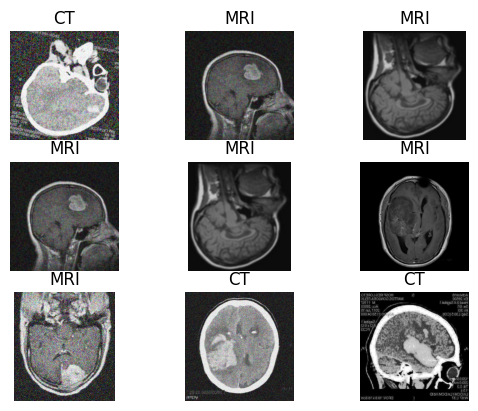

In [28]:
# Data Visualization

n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
c = 0
for row in range(n_rows):
    for col in range(n_cols):
        tuple = aug_train.iloc[c * row + col]
        image = Image.open(tuple['image_paths']).convert("RGB")
        axarr[row, col].imshow(image)
        axarr[row, col].axis('off')
        axarr[row, col].set_title(tuple['labels'])
    c += 1

plt.show()

In [29]:
# Encode classes to numeric values

aug_label_encoder = LabelEncoder()
aug_label_encoder.fit(aug_data_df['labels'])

LabelEncoder()

We keep the transforms and hyperparameters as well as model same.

In [30]:
class aug_dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(aug_label_encoder.transform(dataframe['labels'])) 
    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, ind):
        img_path = self.dataframe['image_paths'].iloc[ind]
        label = self.labels[ind]
        image = Image.open(img_path).convert('RGB')
        if (self.transform):
            image = self.transform(image)
        return image, label


In [31]:
# Creating datasets

aug_train_dataset = aug_dataset(dataframe=aug_train, transform=transform)
aug_test_dataset = aug_dataset(dataframe=aug_test, transform=transform)

In [32]:
# Creating Dataloaders

aug_train_loader = DataLoader(aug_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
aug_test_loader = DataLoader(aug_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

In [33]:
# Reset the original model before creating the augmented one
del model
torch.cuda.empty_cache()

# Getting MobileNetV2
aug_model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

Using cache found in C:\Users\Ankit Dey/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Work\VS Code\ml-research-project\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Work\VS Code\ml-research-project\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
# Checking model parameters

aug_model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [35]:
# Freezing all parameters

for param in aug_model.parameters():
    param.requires_grad = False

# Replacing the classifier for binary Classification

aug_model.classifier[1] = nn.Linear(aug_model.last_channel, 2)

In [36]:
# Moving model to device

aug_model = aug_model.to(device)

In [37]:
summary(aug_model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
             ReLU6-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
       BatchNorm2d-5         [-1, 32, 128, 128]              64
             ReLU6-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 16, 128, 128]             512
       BatchNorm2d-8         [-1, 16, 128, 128]              32
  InvertedResidual-9         [-1, 16, 128, 128]               0
           Conv2d-10         [-1, 96, 128, 128]           1,536
      BatchNorm2d-11         [-1, 96, 128, 128]             192
            ReLU6-12         [-1, 96, 128, 128]               0
           Conv2d-13           [-1, 96, 64, 64]             864
      BatchNorm2d-14           [-1, 96,

In [38]:

# Setting Loss & Optimizer

loss = nn.BCEWithLogitsLoss()
optimizer = Adam(aug_model.classifier.parameters(), lr=LEARNING_RATE)

In [39]:
# Training loop for MobileNetV2 (Augmented Dataset)

total_loss_train_plot = []
total_acc_train_plot = []
total_precision_train_plot = []
total_loss_test_plot = []
total_acc_test_plot = []
total_precision_test_plot = []

for epoch in range(EPOCHS):
    print(f"Starting epoch {epoch+1}")
    epoch_loss = 0
    epoch_acc = 0

    aug_model.train()
    print("About to start training loop...")

    for batch_idx, (inputs, labels) in enumerate(aug_train_loader):
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = aug_model(inputs)
        batch_loss = loss(outputs, nn.functional.one_hot(labels, num_classes=2).float())
        batch_loss.backward()
        optimizer.step()

        epoch_loss += batch_loss.detach()
        preds = torch.argmax(outputs, dim=1)
        epoch_acc += (preds == labels).sum()

        if batch_idx == 0:
            all_preds_gpu = preds
            all_labels_gpu = labels
        else:
            all_preds_gpu = torch.cat([all_preds_gpu, preds])
            all_labels_gpu = torch.cat([all_labels_gpu, labels])

    avg_train_loss = epoch_loss.item() / len(aug_train_loader)
    train_accuracy = (epoch_acc.item() / len(aug_train_dataset)) * 100
    train_precision = precision_score(all_labels_gpu.cpu().numpy(), all_preds_gpu.cpu().numpy(), average='macro') * 100

    total_loss_train_plot.append(round(avg_train_loss, 4))
    total_acc_train_plot.append(round(train_accuracy, 4))
    total_precision_train_plot.append(round(train_precision, 4))

    # Test phase
    aug_model.eval()
    test_loss = 0
    test_acc = 0
    test_preds = []
    test_labels = []
    with torch.no_grad():
        for inputs, labels in aug_test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = aug_model(inputs)
            batch_loss = loss(outputs, nn.functional.one_hot(labels, num_classes=2).float())
            test_loss += batch_loss.detach()

            preds = torch.argmax(outputs, dim=1)
            batch_acc = (preds == labels).sum()
            test_acc += batch_acc

            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss.item() / len(aug_test_loader)
    test_accuracy = test_acc.item() / len(aug_test_dataset) * 100
    test_precision = precision_score(test_labels, test_preds, average='macro') * 100

    total_loss_test_plot.append(round(avg_test_loss, 4))
    total_acc_test_plot.append(round(test_accuracy, 4))
    total_precision_test_plot.append(round(test_precision, 4))

    print(f'''Epoch {epoch+1}/{EPOCHS}, 
    Train Loss: {round(avg_train_loss, 4)} | Train Accuracy: {round(train_accuracy, 4)}% | Train Precision: {round(train_precision, 4)}%
    Test Loss: {round(avg_test_loss, 4)} | Test Accuracy: {round(test_accuracy, 4)}% | Test Precision: {round(test_precision, 4)}%''')
    print("="*50)

Starting epoch 1
About to start training loop...
Epoch 1/3, 
    Train Loss: 0.2487 | Train Accuracy: 92.9682% | Train Precision: 93.0038%
    Test Loss: 0.1131 | Test Accuracy: 97.8554% | Test Precision: 97.9218%
Starting epoch 2
About to start training loop...
Epoch 1/3, 
    Train Loss: 0.2487 | Train Accuracy: 92.9682% | Train Precision: 93.0038%
    Test Loss: 0.1131 | Test Accuracy: 97.8554% | Test Precision: 97.9218%
Starting epoch 2
About to start training loop...
Epoch 2/3, 
    Train Loss: 0.0981 | Train Accuracy: 97.7255% | Train Precision: 97.7282%
    Test Loss: 0.0709 | Test Accuracy: 98.5408% | Test Precision: 98.5517%
Starting epoch 3
About to start training loop...
Epoch 2/3, 
    Train Loss: 0.0981 | Train Accuracy: 97.7255% | Train Precision: 97.7282%
    Test Loss: 0.0709 | Test Accuracy: 98.5408% | Test Precision: 98.5517%
Starting epoch 3
About to start training loop...
Epoch 3/3, 
    Train Loss: 0.0728 | Train Accuracy: 98.2278% | Train Precision: 98.2275%
    T

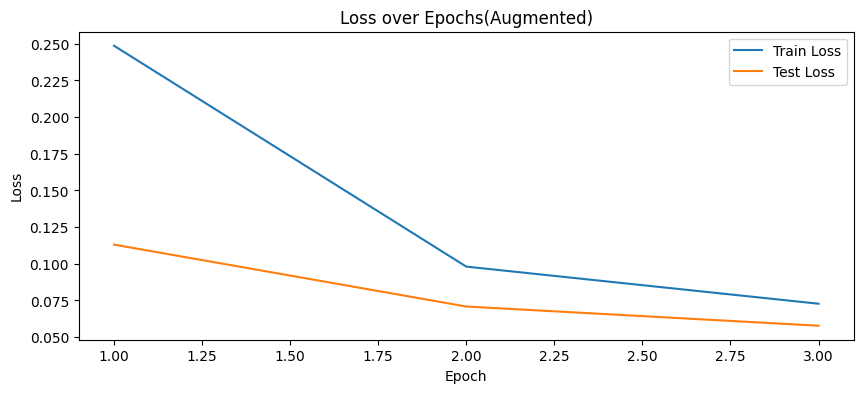

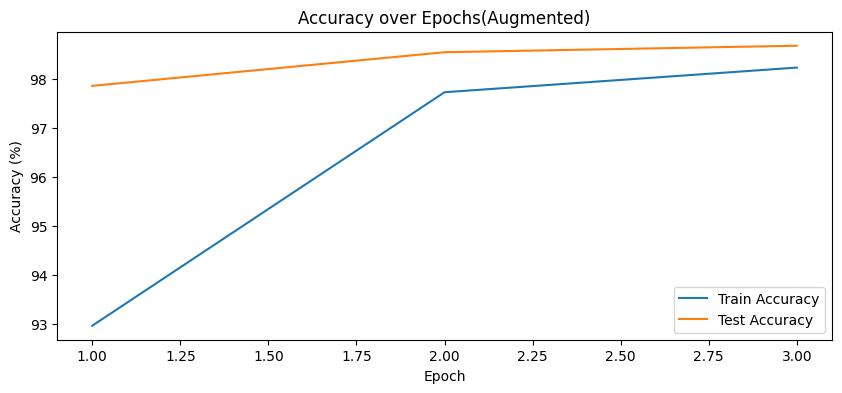

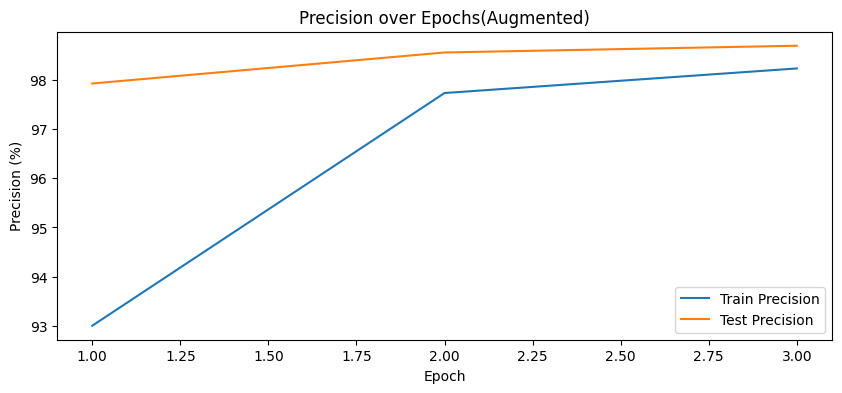

In [40]:
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)

# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(epochs, total_loss_train_plot, label='Train Loss')
plt.plot(epochs, total_loss_test_plot, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs(Augmented)')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.plot(epochs, total_acc_train_plot, label='Train Accuracy')
plt.plot(epochs, total_acc_test_plot, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs(Augmented)')
plt.legend()
plt.show()

# Plot Precision
plt.figure(figsize=(10, 4))
plt.plot(epochs, total_precision_train_plot, label='Train Precision')
plt.plot(epochs, total_precision_test_plot, label='Test Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision (%)')
plt.title('Precision over Epochs(Augmented)')
plt.legend()
plt.show()

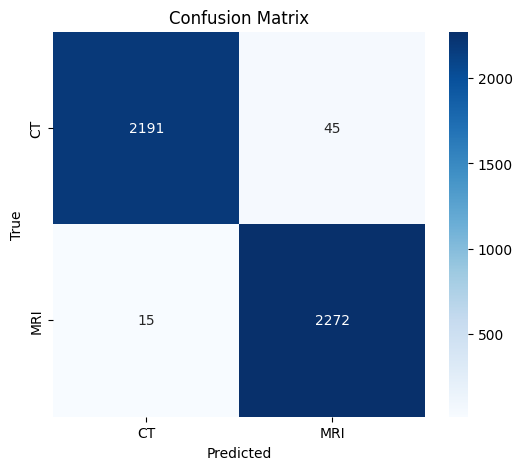

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# After test phase
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['CT', 'MRI'], yticklabels=['CT', 'MRI'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Now let us try the original dataset on the newly trained mobilenet

Augmented Model Performance on Original Dataset:
Accuracy: 99.7574%
Precision: 99.7583%


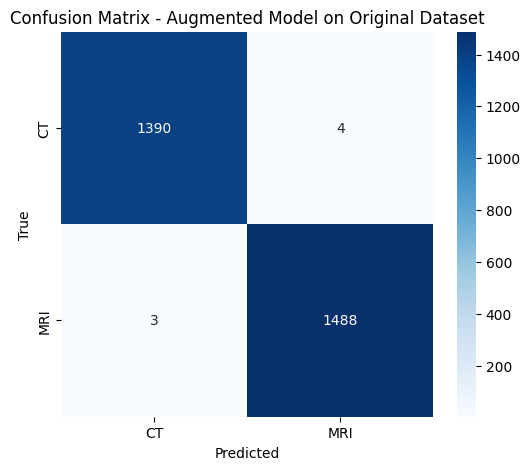

In [42]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

# Evaluate the augmented model on the original dataset (test set)

aug_model.eval()
original_test_preds = []
original_test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = aug_model(inputs)
        preds = torch.argmax(outputs, dim=1)
        
        original_test_preds.extend(preds.cpu().numpy())
        original_test_labels.extend(labels.cpu().numpy())

# Calculate metrics

original_accuracy = accuracy_score(original_test_labels, original_test_preds) * 100
original_precision = precision_score(original_test_labels, original_test_preds, average='macro') * 100

print(f"Augmented Model Performance on Original Dataset:")
print(f"Accuracy: {original_accuracy:.4f}%")
print(f"Precision: {original_precision:.4f}%")

# Plot confusion matrix
cm = confusion_matrix(original_test_labels, original_test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['CT', 'MRI'], yticklabels=['CT', 'MRI'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Augmented Model on Original Dataset')
plt.show()